# **Reducing APF Data Tutorial**
By Zoe Ko

## About this tutorial

This tutorial is intended to show the progression of APF 1D data products. Begin with the reduced 1D spectra and follow four steps to reduce the data:
* Deblaze and normalize the data by dividing out the echelle blaze function
* Transform the wavelength solution of the data to constant RV space
* Download a corresponding synthetic or empirical spectrum and transform its wavelength solution to constant RV space
* Run a chi-squared test on the data and the empirical spectrum to determine doppler shift
* Shift the data to be in the rest frame


## About the data

The APF data can be downloaded from the Breakthrough Listen database, which can be found through the [Breakthrough Listen webpage](https://seti.berkeley.edu/listen/data.html). The solar flux spectrum can be found from [NSO](https://drive.google.com/file/d/12ByZSN1k6MOXBqOO-6Dpqrp1HvHr8b6z/view?usp=sharing).

In [911]:
from astropy.io import fits
import matplotlib.pylab as plt
import numpy as np
import scipy.interpolate
from scipy.interpolate import splev, splrep

## Read in APF Data

This tutorial uses 10 CVn (HIP62207), an F type star. It takes spectra from order 38, which includes wavlengths from approximately 5380 to 5460 Angstroms.

In [905]:
wl_file = fits.open('/mnt_home/zoek/APF_tutorial/apf_wav.fits')
fl_file = fits.open('/datag/blpd0/datax/apf/rarj.224.fits')
wl_image = wl_file[0].data
fl_image = fl_file[0].data

Text(0, 0.5, 'Flux')

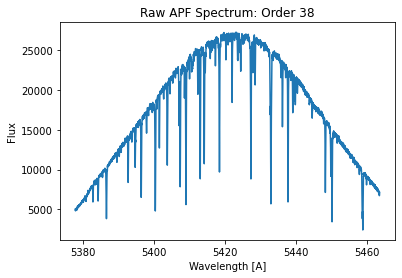

In [906]:
order = 38
wl = wl_image[order]
flux = fl_image[order][:-1]
plt.plot(wl,flux)

plt.title('Raw APF Spectrum: Order ' + str(order))
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')

## Dividing out the Echelle Blaze Function

Divide the data into bins of 100 pixels. Find the flux value in the 95th percentile within each bin and interpolate these flux values onto the wavelength values. Divide the APF flux spectrum by the fit of the 95th percentile flux values.

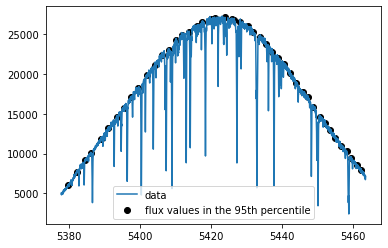

In [907]:
bin = 100

# this list will contain the indices corresponding to each of the 95th percentile flux values in each bin
indices = []

for i in np.arange((len(wl) - (bin)), step = bin):
    flux_values = []
    for j in np.arange(i, i + bin, step = 1):
        value = flux[j]
        flux_values = np.append(flux_values, value)
    # find the 95th percentile flux value: we use 95 to get the maximum flux value in general 
    # but avoid issues with cosmic rays and other emission lines
    flux_in_bin = np.percentile(flux_values, 95)
    # find the closest value in the flux array to the 95th percentile value
    absolute_difference_function = lambda list_value : abs(list_value - flux_in_bin)
    flux_in_bin = min(flux_values.tolist(), key=absolute_difference_function)
    index_in_bin = flux_values.tolist().index(flux_in_bin)
    index = i + index_in_bin
    indices = np.append(indices, index)

# these lists will contain the wavlength and flux values at each index in 'indices'
wl_values = []
fl_values = []

for index in indices:
    ind = int(index)
    wl_values = np.append(wl_values, wl[ind])
    fl_values = np.append(fl_values, flux[ind])
    
plt.plot(wl, flux, label = 'data')
plt.scatter(wl_values, fl_values, color = 'black', label = 'flux values in the 95th percentile')
plt.legend()

Interpolate fl_values onto wl_values so that the length of the arrays match that of the APF spectrum. Set s to 500000 to smooth the fit.

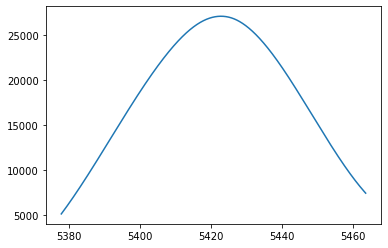

In [908]:
spl = splrep(wl_values, fl_values, s = 500000)
flux_fit = splev(wl, spl)
plt.plot(wl, flux_fit)

Divide out the fit from the data

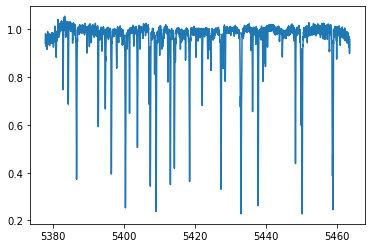

In [909]:
normalized_flux = flux / flux_fit

plt.plot(wl, normalized_flux)

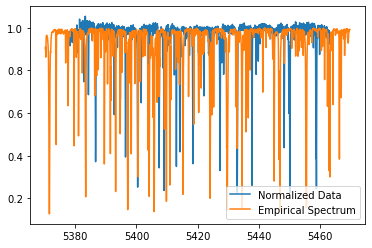

In [910]:
plt.plot(wl, normalized_flux, label = 'Normalized Data')
plt.plot(wl_syn, fl_syn, label = 'Empirical Spectrum')
plt.legend()

Regrid the spectrum to be log lambda spaced so that each shift in pixel is a constant velocity offset. First, interpolate the normalized flux values onto the wavelength grid.

In [912]:
f = scipy.interpolate.interp1d(wl, normalized_flux, kind='cubic')

In [913]:
#create an array of wavelength values that are spaced apart on a log scale (in order to change it to velocity)
dv = 1 # km/s
C = 299792.458 #km/s
wl_start = min(wl) + 0.2
wl_end = max(wl) - 0.2

CDELT1 = np.log10(dv/C +1) # wavelength grid step size

CRVAL1 = np.log10(wl_start)  # log of starting wavelength value
CRVALN = np.log10(wl_end)    # log of ending wavelength value 
NAXIS1 = (CRVALN - CRVAL1) / CDELT1  # total number of points

p = np.arange(NAXIS1) # array of total points
wl = 10 ** (CRVAL1 + CDELT1 * p)  # new array of wavelength values

# interpolate flux values onto log spaced wavelength grid
flux = f(wl)

Plot the new wavelength grid against flux values. This should look the same as before; however, the wavelengths are now velocity spaced.

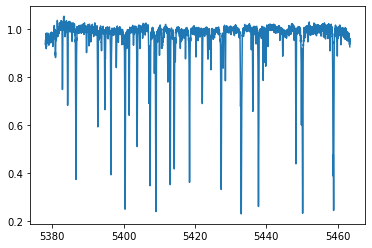

In [914]:
plt.plot(wl, flux)

## Empirical Solar Spectrum
Read the empirical solar spectrum using astropy.io.fits. There are two arrays: one is the wavelength from around 3000 angstroms to 12,500 Angstroms, and the second is the corresponding flux array. Truncate it to around 5380 to 5460 Angstroms to match the APF data.

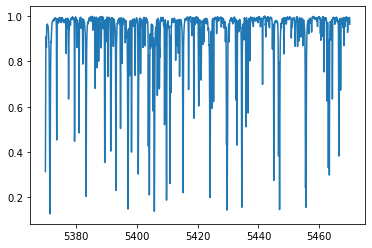

In [915]:
solar_spectrum = fits.open('/mnt_home/zoek/APF_tutorial/nso.fits') # write correct path name
wl_temp = solar_spectrum[0].data
fl_temp = solar_spectrum[1].data

min_ind = wl_temp.tolist().index((5370.005479812622))
max_ind = wl_temp.tolist().index((5470.009880065918))

wl_syn_temp = wl_temp[416683:430975]
fl_syn_temp = fl_temp[416683:430975]

plt.plot(wl_syn_temp, fl_syn_temp)

Regrid the synthetic spectrum to be log lambda spaced (contant velocity).

In [916]:
f = scipy.interpolate.interp1d(wl_syn_temp, fl_syn_temp, kind='cubic')

In [917]:
#create an array of wavelength values that are spaced apart on a log scale (in order to change it to velocity)
dv = 1 #km/s
C = 299792.458 #km/s
wl_start = min(wl_syn_temp) + 0.2
wl_end = max(wl_syn_temp) - 0.2

CDELT1 = np.log10(dv/C +1) #wavelength grid step size

CRVAL1 = np.log10(wl_start)  #log of starting wavelength value
CRVALN = np.log10(wl_end)    #log of ending wavelength value 
NAXIS1 = (CRVALN - CRVAL1) /CDELT1  #total number of points

p = np.arange(NAXIS1) #array of total points
wl_syn = 10 ** (CRVAL1 + CDELT1 * p)  #array of wavelength values

# interpolate flux values onto log spaced wavelength grid
fl_syn = f(wl_syn)

Plot the new wavelength grid against flux values. This should look the same as before; however, the wavelengths are now velocity spaced.

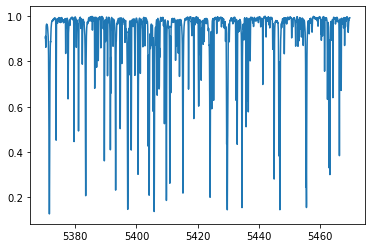

In [918]:
plt.plot(wl_syn, fl_syn)

## Finding the velocity shift of the data from the empirical spectrum

First find the current offset of the APF spectrum and the empirical spectrum

In [919]:
for wavelength in wl_syn:
    if (min(wl) - 0.02) < wavelength < (min(wl) + 0.02):
        x = wavelength

index = wl_syn.tolist().index(x)
print('The first value of the APF data is located at pixel ' + str(index) + ' of the empirical spectrum.')

The first value of the APF data is located at pixel 438 of the empirical spectrum.


Run a chi squared test to determine the pixel offset of the data and the empirical spectrum.

The APF spectrum needs to be redshifted by 181 pixels. (Shift to left.)


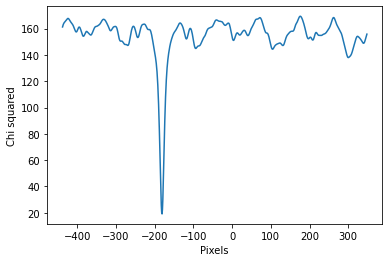

In [920]:
def chi(model, data):
    '''given two arrays of the same length,
    calculate chi squared'''
    return np.sum((data - model) ** 2)

chi_squared_values = []
indices = []

for i in np.arange(len(wl_syn) - len(wl)):
    syn_flux = fl_syn[i: i + len(wl)]
    chi_squared = chi(syn_flux, flux)
    chi_squared_values = np.append(chi_squared_values, chi_squared)
    indices = np.append(indices, i)
    
min_chi = min(chi_squared_values)
shifted_index = chi_squared_values.tolist().index(min_chi)

plt.plot(indices - index, chi_squared_values)
plt.xlabel('Pixels')
plt.ylabel('Chi squared')

if (shifted_index - index) < 0:
    shift = index - shifted_index
    print('The APF spectrum needs to be redshifted by ' + str(shift) + ' pixels. (Shift to left.)')
    shift_dir = 'left'
else:
    shift = shifted_index - index
    print('The APF spectrum needs to be blueshifted by ' + str(shift) + ' pixels. (Shift to right.)')
    shift_dir = 'right'

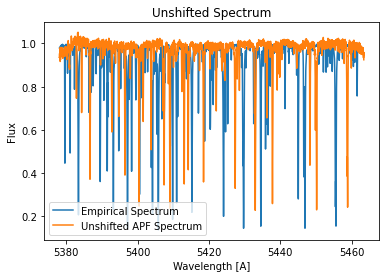

In [921]:
wl_syn_plot = wl_syn[index:-index]
fl_syn_plot = fl_syn[index:-index]

if shift_dir == 'left':
    shifted_wl = wl[:-shift]
    shifted_fl = flux[shift:]
else:
    shifted_wl = wl[shift:]
    shifted_fl = flux[:-shift]

plt.plot(wl_syn_plot, fl_syn_plot, label = 'Empirical Spectrum')
plt.plot(wl, flux, label = 'Unshifted APF Spectrum')

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Unshifted Spectrum')

plt.legend()

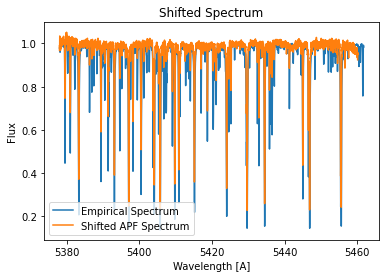

In [923]:
plt.plot(wl_syn_plot, fl_syn_plot, label = 'Empirical Spectrum')
plt.plot(shifted_wl, shifted_fl, label = 'Shifted APF Spectrum')

plt.title('Shifted Spectrum')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.legend()

## Final Product
Now we have a normalized, deblazed APF spectrum, shifted so that it is in its rest frame.

Text(0, 0.5, 'Flux')

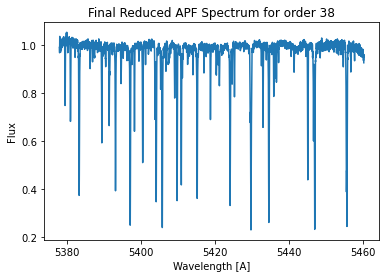

In [924]:
plt.plot(shifted_wl, shifted_fl)
plt.title('Final Reduced APF Spectrum for order ' + str(order))
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')